## Imports

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


# Get data and data split

In [2]:
data = pd.read_csv('new_Exam_Score_Prediction.csv')

y = data['exam_score']
X = data.drop('exam_score', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
x_train

,study_hours,class_attendance,facility_rating,gender,coaching,self_study
1156,5.57,43.4,2,1,0,1
1536,3.52,61.1,2,0,1,0
5035,1.83,58.6,1,0,0,0
9040,7.17,44.1,1,1,1,0
7272,5.06,86.1,2,1,1,0
...,...,...,...,...,...,...
11964,0.39,58.0,0,1,0,0
5191,2.44,74.7,2,0,0,1
5390,0.90,92.3,2,0,0,0
860,7.51,72.8,2,1,1,0


# Metric and Optim Functions

## Metric Function

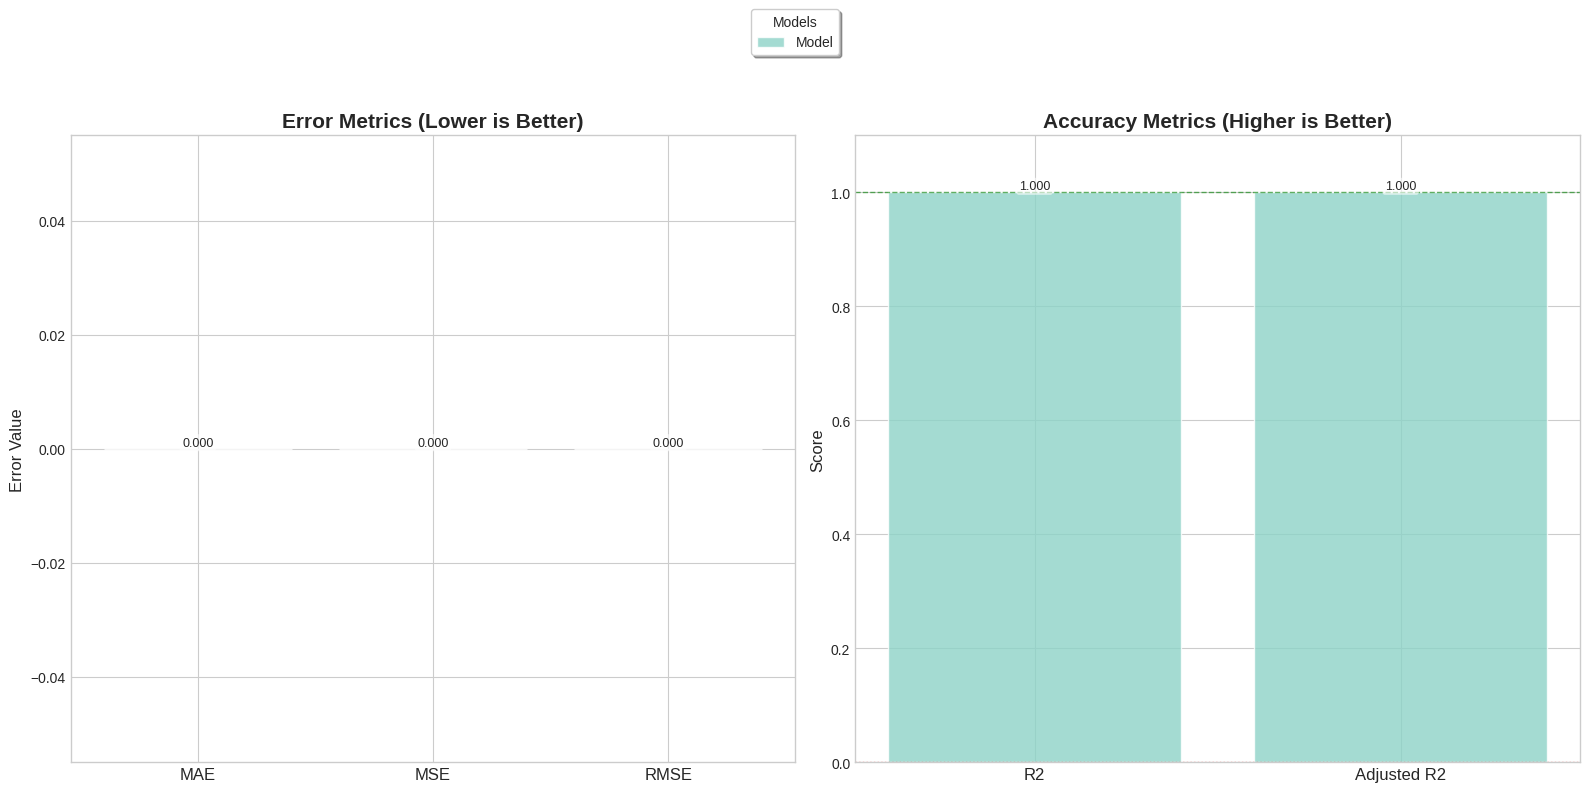

,Metric,Value
0,MAE,0.0
1,MSE,0.0
2,RMSE,0.0
3,R2,1.0
4,Adjusted R2,1.0


In [3]:
def metric(y_hat, y_true,features_shape):
    n,p = features_shape
    r2 = r2_score(y_true, y_hat)
    socres = {
        "MAE": mean_absolute_error(y_true, y_hat),
        "MSE": mean_squared_error(y_true, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_hat)),
        "R2": r2,
        "Adjusted R2":  1 - (1 - r2) * (n - 1) / (n - p - 1)
    }

    df_score = pd.DataFrame(socres.items(), columns=["Metric","Value"])

    return df_score


dummy  = metric(y_train, y_train, x_train.shape)


def plot_meterics(df_dict):
    if isinstance(df_dict, pd.DataFrame):
        df_dict = {'Model': df_dict}

    # Split metrics into two groups
    error_metrics = ["MAE", "MSE", "RMSE"]
    accuracy_metrics = ["R2", "Adjusted R2"]

    # Combine dataframes
    all_data = []
    for model_name, df in df_dict.items():
        temp_df = df.copy()
        temp_df['Model'] = model_name
        all_data.append(temp_df)

    if not all_data:
        print("Error: No data available to plot.")
        return

    combined_df = pd.concat(all_data, ignore_index=True)
    models = combined_df['Model'].unique()
    n_models = len(models)
    bar_width = 0.8 / n_models

    # --- Plotting Structure: 1 row, 2 columns ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    def draw_group(ax, metrics_list, title, is_accuracy=False):
        x_base = np.arange(len(metrics_list))

        for i, model in enumerate(models):
            # Extract values for specific metrics in order
            model_subset = combined_df[combined_df['Model'] == model]
            values = [model_subset[model_subset['Metric'] == m]['Value'].values[0]
                      if m in model_subset['Metric'].values else 0 for m in metrics_list]

            offset = (i - (n_models - 1) / 2) * bar_width
            bars = ax.bar(x_base + offset, values, bar_width, label=model, alpha=0.8)

            # Add text labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, height,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9,
                        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

        ax.set_xticks(x_base)
        ax.set_xticklabels(metrics_list, fontsize=12, fontweight='medium')
        ax.set_title(title, fontsize=15, fontweight='bold')

        if is_accuracy:
            ax.axhline(1.0, color='green', linestyle='--', linewidth=1, alpha=0.6, label='Ideal (1.0)')
            ax.axhline(0.0, color='red', linestyle=':', linewidth=1, alpha=0.6)
            ax.set_ylim(min(0, combined_df[combined_df['Metric'].isin(accuracy_metrics)]['Value'].min() - 0.1), 1.1)

    # Draw Left Plot (Errors)
    draw_group(ax1, error_metrics, "Error Metrics (Lower is Better)")
    ax1.set_ylabel('Error Value', fontsize=12)

    # Draw Right Plot (R2)
    draw_group(ax2, accuracy_metrics, "Accuracy Metrics (Higher is Better)", is_accuracy=True)
    ax2.set_ylabel('Score', fontsize=12)

    # Global Legend
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05),
               ncol=min(n_models, 4), title="Models", frameon=True, shadow=True)

    plt.tight_layout()
    plt.show()




plot_meterics(dummy)
dummy

In [4]:
results_dict = {}

# Choosing the best selectors

In [76]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE, SelectFromModel


def create_Pipes(model, k=5, n_df_features=5):
    baseline = Pipeline([('sclaer', StandardScaler()), ('regressor', model)])
    kbest = Pipeline([('sclaer', StandardScaler()), ('features_selector', SelectKBest(f_regression, k=5)),('regressor', model)])
    rfe = Pipeline([('sclaer', StandardScaler()), ('features_selector', RFE(n_features_to_select=5, estimator=LinearRegression())),('regressor', model)])
    mbs = Pipeline([('sclaer', StandardScaler()), ('features_selector', SelectFromModel(Lasso())), ('regressor', model)])

    #TO DO - CV Method Selection
    pipes = {'baseline': baseline, 'kbest': kbest, 'rfe': rfe, 'mbs': mbs}
    names = pipes.keys()
    scores = {}

    for name in names:
        clf = pipes[name]

        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        scores[name] = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    scores = ({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)})

    df_result = pd.DataFrame.from_dict(scores, orient='index')
    df_result.columns = ["neg_MSE score"]

    print(df_result)
    print()

    best = pipes[list(scores.keys())[0]]
    result_dict = {
        "BaseLine": baseline,
        'KBest': kbest,
        'RFE': rfe,
        'MBS': mbs,
        'Best_cv': best
    }

    return result_dict

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor





models = [LinearRegression(), DecisionTreeRegressor(),RandomForestRegressor(), SVR(), XGBRegressor()]
model_names = ['Linear', 'Tree', 'Forest', 'SVR', 'XGB']
model_dict = dict(zip(model_names, models))

model_dict
for name in model_names:
    print(name)
    pipes[name] = create_Pipes(model_dict[name], k=6, n_df_features=6)['Best_cv']

pipes

Linear
          neg_MSE score
kbest       -118.787710
rfe         -118.787710
mbs         -118.787710
baseline    -118.811727

Tree
          neg_MSE score
rfe         -248.464534
kbest       -249.608662
mbs         -250.645446
baseline    -252.047831

Forest
          neg_MSE score
baseline    -138.714506
kbest       -139.837336
mbs         -139.975795
rfe         -140.224802

SVR
          neg_MSE score
kbest       -121.571135
rfe         -121.571135
mbs         -121.571135
baseline    -122.214580

XGB
          neg_MSE score
baseline    -138.663292
kbest       -139.288152
rfe         -139.288152
mbs         -139.288152



{'LinearRegression()': Pipeline(steps=[('feature_selection',
                  SelectKBest(k=5,
                              score_func=<function f_regression at 0x7d660d8937e0>)),
                 ('regressor', LinearRegression())]),
 'DecisionTreeRegressor()': Pipeline(steps=[('feature_selection',
                  SelectKBest(k=5,
                              score_func=<function f_regression at 0x7d660d8937e0>)),
                 ('regressor', DecisionTreeRegressor())]),
 'RandomForestRegressor()': Pipeline(steps=[('regressor', RandomForestRegressor())]),
 'Linear': Pipeline(steps=[('sclaer', StandardScaler()),
                 ('features_selector',
                  SelectKBest(k=5,
                              score_func=<function f_regression at 0x7d660d8937e0>)),
                 ('regressor', LinearRegression())]),
 'Tree': Pipeline(steps=[('sclaer', StandardScaler()),
                 ('features_selector',
                  RFE(estimator=LinearRegression(), n_features_to_s

## Train and optim function
We change models and optimize for model parameters and KBest Feature Selector

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import optuna

names = x_train.columns
optuna.logging.set_verbosity(optuna.logging.WARNING)


def selected_features(selector):
    mask = selector.get_support()
    selected_names = names[mask]
    return list(selected_names)

def optimize_train_and_judge(selector_class,model_class, objective_fn, trails=100):
    global x_train, y_train, x_test, y_test, names

    study = optuna.create_study(direction="maximize")

    start = time.time()
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)
    stop = time.time()

    best_params = study.best_params.copy()
    print(best_params)


    if selector_class is not None:
        if selector_class is SelectKBest:
            pipe = Pipeline([('sclaer', StandardScaler()), ('features_selector', SelectKBest(score_func=f_regression)), ('regressor', model_class())])
        else:
            best_params['features_selector__estimator'] = LinearRegression() if best_params['features_selector__estimator']=='Linear' else Lasso()

            if selector_class is RFE or selector_class is SelectFromModel:
                pipe = Pipeline([('sclaer', StandardScaler()), ('features_selector', selector_class(estimator=LinearRegression())), ('regressor', model_class())])
            else:
                pipe = Pipeline([('sclaer', StandardScaler()), ('features_selector', selector_class()), ('regressor', model_class())])
    else:
        pipe = Pipeline([('sclaer', StandardScaler()), ('regressor', model_class())])

    pipe.set_params(**best_params)

    pipe.fit(x_train, y_train)
    y_hat_test = pipe.predict(x_test)

    if selector_class is not None:
        selector = pipe.named_steps['features_selector']
        names_selected = selected_features(selector)
        features_shape = [x_test.shape[0], len(names_selected)]
    else:
        features_shape = x_test.shape
        names_selected = names

    df_test = metric(y_hat_test, y_test, features_shape)

    new_row_df = pd.DataFrame({
    'Metric': ['n_features_selected', 'time'],
    'Value': [len(names_selected), stop-start]
    })
    df_result = pd.concat([df_test, new_row_df], axis=0, ignore_index=True)
    return pipe, df_result

# Pipelines

## Linear Regression with Kbest

In [60]:
def objective_linear(trial):
    global pipes
    num_features = x_train.shape[1]
    k = trial.suggest_int('features_selector__k', 1, num_features)

    pipe = pipes['Linear']


    score = cross_val_score(pipe,x_train,
        y_train,
        n_jobs=-1,
        cv=5,
        scoring='neg_mean_squared_error'
    ).mean()

    return score

LinearPipe, results_dict['Linear'] = optimize_train_and_judge(SelectKBest, LinearRegression, objective_linear)
results_dict['Linear']

  0%|          | 0/100 [00:00<?, ?it/s]

{'features_selector__k': 1}


,Metric,Value
0,MAE,10.497178
1,MSE,171.965329
2,RMSE,13.113555
3,R2,0.507587
4,Adjusted R2,0.507464
5,n_features_selected,1.000000
6,time,6.343467


# Tree

In [80]:
def objective_dt(trial):
    global x_train, y_train


    estimator_name = trial.suggest_categorical('features_selector__estimator', ['Linear', 'Lasso'])
    estimator = LinearRegression() if estimator_name=='Linear' else Lasso()

    params = {
        'features_selector__n_features_to_select' :trial.suggest_int("features_selector__n_features_to_select", 1, 6),

        'regressor__ccp_alpha': trial.suggest_float('regressor__ccp_alpha', 0.0, 0.25),
        'regressor__criterion': trial.suggest_categorical('regressor__criterion',
                                                         ['squared_error', 'friedman_mse', 'absolute_error']),
        'regressor__min_samples_split': trial.suggest_int('regressor__min_samples_split', 2, 20)
    }

    # 3. Define the Pipeline
    pipe = pipes['Tree']
    pipe.set_params(features_selector__estimator=estimator)
    pipe.set_params(**params)

    score = cross_val_score(
        pipe,
        x_train,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    ).mean()

    return score

TreePipe, results_dict['Tree'] = optimize_train_and_judge(RFE, DecisionTreeRegressor, objective_dt, trails=1)
results_dict['Tree']

  0%|          | 0/1 [00:00<?, ?it/s]

{'features_selector__estimator': 'Linear', 'features_selector__n_features_to_select': 1, 'regressor__ccp_alpha': 0.035676557441929685, 'regressor__criterion': 'absolute_error', 'regressor__min_samples_split': 8}


,Metric,Value
0,MAE,10.625017
1,MSE,176.693143
2,RMSE,13.292597
3,R2,0.494050
4,Adjusted R2,0.493922
5,n_features_selected,1.000000
6,time,2.001083


# RandomForestRegressor

In [9]:

def objective_rf(trial):
    k = trial.suggest_int('features_selector__k', 1, x_train.shape[1])

    params = {
        'regressor__n_estimators': trial.suggest_int('regressor__n_estimators', 10, 200),
        'regressor__max_depth': trial.suggest_int('regressor__max_depth', 2, 32),
    }

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('features_selector', SelectKBest(score_func=f_regression, k=k)),
        ('regressor', RandomForestRegressor())
    ])

    pipe.set_params(**params)

    score = cross_val_score(pipe, x_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

ForestPipe, results_dict['RandomForestRegressor'] = optimize_train_and_judge('RandomForestRegressor', RandomForestRegressor, objective_rf, trails=20)
results_dict['RandomForestRegressor']

  0%|          | 0/20 [00:00<?, ?it/s]

Selected features: ['study_hours', 'class_attendance', 'facility_rating', 'coaching', 'self_study']
Optimize time: 90.58249378204346


,Metric,Value
0,MAE,9.022806
1,MSE,125.594405
2,RMSE,11.206891
3,R2,0.640368
4,Adjusted R2,0.639916


# SVR

In [10]:
def objective_svr(trial):
    global x_train, y_train


    k = trial.suggest_int('features_selector__k', 1, x_train.shape[1])

    params = {
        'regressor__C': trial.suggest_float('regressor__C', 1e-3, 1e2, log=True),
        'regressor__epsilon': trial.suggest_float('regressor__epsilon', 1e-4, 1.0, log=True),
        'regressor__kernel': trial.suggest_categorical('regressor__kernel', ['rbf', 'poly', 'sigmoid']),
        'regressor__gamma': trial.suggest_categorical('regressor__gamma', ['scale', 'auto'])
    }

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('features_selector', SelectKBest(score_func=f_regression, k=k)),
        ('regressor', SVR())
    ])
    pipe.set_params(**params)

    score = cross_val_score(
        pipe,
        x_train,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    ).mean()

    return score

SVRPipe, results_dict['SVR'] = optimize_train_and_judge('SVR', SVR, objective_svr, trails=20)
results_dict['SVR']

  0%|          | 0/20 [00:00<?, ?it/s]

Selected features: ['study_hours', 'class_attendance', 'facility_rating', 'coaching', 'self_study']
Optimize time: 84.75774192810059


,Metric,Value
0,MAE,8.792724
1,MSE,120.506513
2,RMSE,10.977546
3,R2,0.654937
4,Adjusted R2,0.654503


# XGBoost

In [11]:
def objective_xgb(trial):
    global x_train, y_train

    k = trial.suggest_int('features_selector__k', 1, x_train.shape[1])

    params = {
        # General Booster params
        'regressor__n_estimators': trial.suggest_int('regressor__n_estimators', 100, 1000),
        'regressor__learning_rate': trial.suggest_float('regressor__learning_rate', 1e-3, 0.3, log=True),
        'regressor__max_depth': trial.suggest_int('regressor__max_depth', 3, 10),

        # Regularization & Overfitting
        'regressor__min_child_weight': trial.suggest_int('regressor__min_child_weight', 1, 10),
        'regressor__subsample': trial.suggest_float('regressor__subsample', 0.5, 1.0),
        'regressor__colsample_bytree': trial.suggest_float('regressor__colsample_bytree', 0.5, 1.0),

        # L1 and L2 regularization
        'regressor__reg_alpha': trial.suggest_float('regressor__reg_alpha', 1e-8, 1.0, log=True),
        'regressor__reg_lambda': trial.suggest_float('regressor__reg_lambda', 1e-8, 1.0, log=True),

        'regressor__random_state': 42,
        'regressor__n_jobs': -1
    }

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('features_selector', SelectKBest(score_func=f_regression, k=k)),
        ('regressor', XGBRegressor())
    ])

    pipe.set_params(**params)

    score = cross_val_score(
        pipe,
        x_train,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error'
    ).mean()

    return score

XGBPipe, results_dict['XGBPipe'] = optimize_train_and_judge('XGBPipe', XGBRegressor, objective_xgb, trails=20)
results_dict['XGBPipe']

  0%|          | 0/20 [00:00<?, ?it/s]

Selected features: ['study_hours', 'class_attendance', 'facility_rating', 'coaching', 'self_study']
Optimize time: 74.64605736732483


,Metric,Value
0,MAE,8.806771
1,MSE,120.474321
2,RMSE,10.976079
3,R2,0.655029
4,Adjusted R2,0.654595


# Result Comprehension

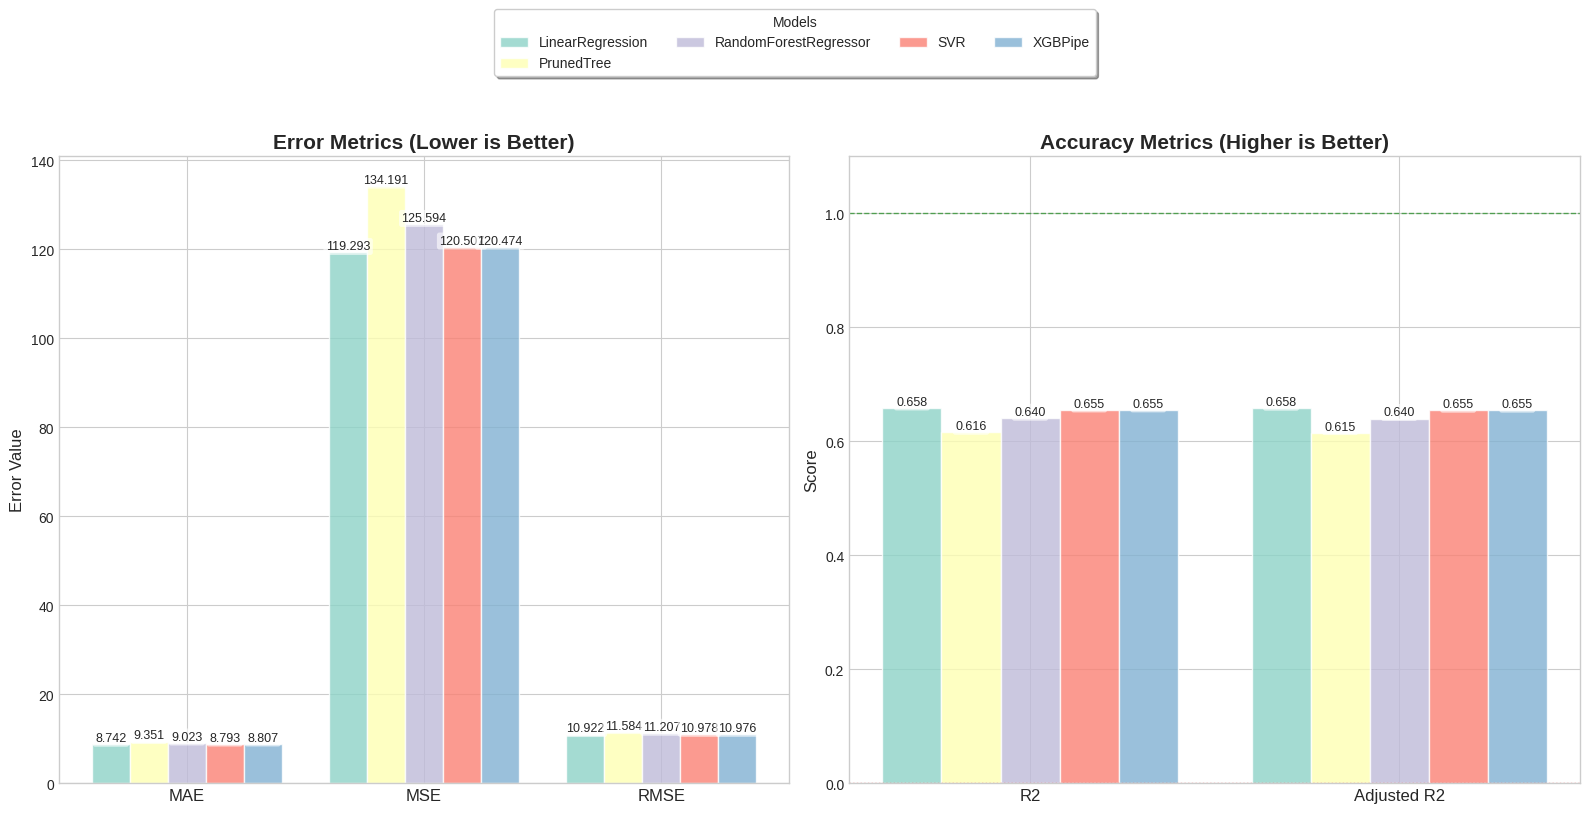

In [12]:
plot_meterics(results_dict)

# Saving Pipes
Via Pickle

In [13]:
import pickle
import os

PATH = 'pipes'

with open(os.path.join(PATH, 'Linear.pkl'), 'wb') as f:
    pickle.dump(LinearPipe, f)

with open(os.path.join(PATH, 'Tree.pkl'), 'wb') as f:
    pickle.dump(TreePipe, f)

with open(os.path.join(PATH, 'Forest.pkl'), 'wb') as f:
    pickle.dump(ForestPipe, f)

with open(os.path.join(PATH, 'SVR.pkl'), 'wb') as f:
    pickle.dump(SVRPipe, f)

with open(os.path.join(PATH, 'XSB.pkl'), 'wb') as f:
    pickle.dump(XGBPipe, f)

